# MLDA experiment in Basin

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

In [2]:
import datetime
timestamp = datetime.datetime.now().strftime("%Y-%m-%dT%H_%M_%S")


GPU Ocean-modules:

In [3]:
from gpuocean.utils import IPythonMagic, Common
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL

In [4]:
%cuda_context_handler gpu_ctx

In [5]:
gpu_stream = cuda.Stream()

Utils

In [6]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *
from utils.BasinPlot import *

In [7]:
truth_path = "/home/florianb/havvarsel/multilevelDA/scripts/DataAssimilation/BasinTruth/2023-06-22T13_47_48"

## Case 

In [8]:
ls = [6, 7, 8, 9]

In [9]:
from utils.BasinParameters import * 

In [10]:
args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "gpu_stream": gpu_stream,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        } )

In [11]:
data_args_list = []
for l_idx in range(len(args_list)): 
    data_args_list.append( make_init_steady_state(args_list[l_idx], a=steady_state_bump_a, bump_fractal_dist=steady_state_bump_fractal_dist) )


In [12]:
Nes = [100, 50, 20, 5]

In [13]:
from gpuocean.ensembles import MultiLevelOceanEnsemble
MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsembleCase(Nes, args_list, data_args_list, sample_args, make_sim,
                            init_model_error_basis_args=init_model_error_basis_args, 
                            sim_model_error_basis_args=sim_model_error_basis_args, sim_model_error_timestep=sim_model_error_timestep)

from gpuocean.dataassimilation import MLEnKFOcean
MLEnKF = MLEnKFOcean.MLEnKFOcean(MLOceanEnsemble)

In [14]:
MLOceanEnsemble.stepToObservation(da_timestep)

In [15]:
from utils.BasinSL import *

def g_functionalExp(SL_state):
    """
    L_g functional as in notation of Kjetil's PhD thesis.
    This should be the functional that is under investigation for the variance level plot

    Input a ndarray of size (3, ny, nx, Ne)

    Returns a ndarray of same size as SL_state (3, ny, nx, Ne)
    """
    return SL_state

def g_functionalVar(SL_state):
    """
    L_g functional as in notation of Kjetil's PhD thesis.
    This should be the functional that is under investigation for the variance level plot

    Input a ndarray of size (3, ny, nx, Ne)

    Returns a ndarray of same size as SL_state (3, ny, nx, Ne)
    """
    return (SL_state - np.mean(SL_state, axis=-1)[:,:,:,np.newaxis])**2
    
def L2norm(field, lvl_grid_args):
    """
    integral_D(f dx)
    where D are uniform finite volumes

    Input:
    field           - ndarray of shape (3,ny,nx,..)
    lvl_grid_args   - dict with nx, ny and dx, dy information

    Output:
    L2norm          - ndarray of shape (3,...)
    """
    # assert field.shape[1:3] == (lvl_grid_args["ny"], lvl_grid_args["nx"]), "field has wrong resolution"
    return np.sqrt(np.sum((field)**2 * lvl_grid_args["dx"]*lvl_grid_args["dy"], axis=(1,2)))



In [16]:
ML_state = MLOceanEnsemble.download()

In [17]:
centers = []
for l_idx in range(len(ls)): 
    center_N = int(args_list[l_idx]["nx"]/8)
    center_x = int(args_list[l_idx]["nx"]/2)
    center_y = int(args_list[l_idx]["ny"]/2)
    centers.append( np.s_[:, center_y-center_N:center_y+center_N, center_x-center_N:center_x+center_N,:] )

In [18]:
prior_gExp = np.zeros((len(ls),3))
prior_gVar = np.zeros((len(ls),3))
prior_gExp_diff = np.zeros((len(ls),3))
prior_gVar_diff = np.zeros((len(ls),3))

In [19]:
prior_gExp[0] = L2norm(np.var(g_functionalExp(ML_state[0][centers[l_idx]]),ddof=1, axis=-1), args_list[0])
prior_gVar[0] = L2norm(np.var(g_functionalVar(ML_state[0][centers[l_idx]]),ddof=1, axis=-1), args_list[0])

for l_idx in range(1,len(ls)):
    prior_gExp[l_idx] = L2norm(np.var(g_functionalExp(ML_state[l_idx][0][centers[l_idx]]),ddof=1, axis=-1), args_list[l_idx])
    prior_gVar[l_idx] = L2norm(np.var(g_functionalVar(ML_state[l_idx][0][centers[l_idx]]),ddof=1, axis=-1), args_list[l_idx])

    prior_gExp_diff[l_idx] = L2norm(np.var(g_functionalExp(ML_state[l_idx][0][centers[l_idx]]) - g_functionalExp(ML_state[l_idx][1].repeat(2,1).repeat(2,2)[centers[l_idx]]),ddof=1, axis=-1), args_list[l_idx])
    prior_gVar_diff[l_idx] = L2norm(np.var(g_functionalVar(ML_state[l_idx][0][centers[l_idx]]) - g_functionalVar(ML_state[l_idx][1].repeat(2,1).repeat(2,2)[centers[l_idx]]),ddof=1, axis=-1), args_list[l_idx])


In [20]:
prior_gVar, prior_gVar_diff

(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.71577168e+00, 3.58021400e+07, 3.37487920e+07],
        [1.96688449e+00, 5.89662880e+07, 2.57902060e+07],
        [6.15203977e-01, 9.70119800e+06, 1.71737340e+07]]),
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.85384378e-02, 2.94368875e+05, 5.84111812e+05],
        [3.65499104e-03, 1.11348234e+05, 1.22319281e+05],
        [2.79158005e-04, 4.38307666e+03, 3.01418516e+04]]))

Data Assimilation

In [21]:
truth = make_sim(args_list[-1], sample_args, data_args_list[-1])
init_mekl = ModelErrorKL.ModelErrorKL(**args_list[-1], **init_model_error_basis_args) 
init_mekl.perturbSim(truth)
truth.setKLModelError(**sim_model_error_basis_args)
truth.model_time_step = sim_model_error_timestep

In [22]:
precomp_GC = []
for obs_x, obs_y in zip(obs_xs, obs_ys):
    precomp_GC.append( MLEnKF.GCweights(obs_x, obs_y, r) )

In [23]:
# DA step
truth.dataAssimilationStep(MLOceanEnsemble.t)
true_eta, true_hu, true_hv = truth.download()

for h, [obs_x, obs_y] in enumerate(zip(obs_xs, obs_ys)):
    Hx, Hy = MLOceanEnsemble.obsLoc2obsIdx(obs_x, obs_y)
    obs = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)
    
    prior = copy.deepcopy(MLOceanEnsemble.download())

    ML_K = MLEnKF.assimilate(MLOceanEnsemble, obs, obs_x, obs_y, R, 
                            r=r, obs_var=slice(1,3), relax_factor=relax_factor, 
                            min_localisation_level=0,
                            precomp_GC=precomp_GC[h])

In [24]:
ML_state = MLOceanEnsemble.download()

In [25]:
posterior_gExp = np.zeros((len(ls),3))
posterior_gVar = np.zeros((len(ls),3))
posterior_gExp_diff = np.zeros((len(ls),3))
posterior_gVar_diff = np.zeros((len(ls),3))

In [26]:
posterior_gExp[0] = L2norm(np.var(g_functionalExp(ML_state[0][centers[l_idx]]),ddof=1, axis=-1), args_list[0])
posterior_gVar[0] = L2norm(np.var(g_functionalVar(ML_state[0][centers[l_idx]]),ddof=1, axis=-1), args_list[0])

for l_idx in range(1,len(ls)):
    posterior_gExp[l_idx] = L2norm(np.var(g_functionalExp(ML_state[l_idx][0][centers[l_idx]]),ddof=1, axis=-1), args_list[l_idx])
    posterior_gVar[l_idx] = L2norm(np.var(g_functionalVar(ML_state[l_idx][0][centers[l_idx]]),ddof=1, axis=-1), args_list[l_idx])
    
    posterior_gExp_diff[l_idx] = L2norm(np.var(g_functionalExp(ML_state[l_idx][0][centers[l_idx]]) - g_functionalExp(ML_state[l_idx][1].repeat(2,1).repeat(2,2)[centers[l_idx]]),ddof=1, axis=-1), args_list[l_idx])
    posterior_gVar_diff[l_idx] = L2norm(np.var(g_functionalVar(ML_state[l_idx][0][centers[l_idx]]) - g_functionalVar(ML_state[l_idx][1].repeat(2,1).repeat(2,2)[centers[l_idx]]),ddof=1, axis=-1), args_list[l_idx])


In [27]:
posterior_gVar, posterior_gVar_diff

(array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.92332995e+00, 2.48485760e+07, 2.60812960e+07],
        [1.38010657e+00, 3.92565520e+07, 2.31005000e+07],
        [4.24676239e-01, 5.96298100e+06, 1.24733950e+07]]),
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.33435000e-02, 2.07983203e+05, 4.76388188e+05],
        [2.42266012e-03, 6.78742188e+04, 1.02014055e+05],
        [1.24580925e-04, 2.13500122e+03, 1.68609531e+04]]))

Comparison

In [28]:
posterior_gVar/prior_gVar

c:\Users\florianb\Miniconda3\envs\gpuocean_opendrift\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[       nan,        nan,        nan],
       [0.70820753, 0.69405281, 0.7728068 ],
       [0.70167139, 0.66574569, 0.89570824],
       [0.69030152, 0.6146644 , 0.72630652]])

In [29]:
posterior_gVar_diff/prior_gVar_diff

c:\Users\florianb\Miniconda3\envs\gpuocean_opendrift\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([[       nan,        nan,        nan],
       [0.71977478, 0.70653938, 0.81557705],
       [0.66283613, 0.60956709, 0.83399815],
       [0.44627388, 0.48710104, 0.55938677]])

Over time

In [30]:
updates_gVar = [posterior_gVar/prior_gVar]
updates_gVar_diff = [posterior_gVar_diff[1:]/prior_gVar_diff[1:]]

c:\Users\florianb\Miniconda3\envs\gpuocean_opendrift\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [31]:
while MLOceanEnsemble.t < T_da:
    # Forward step
    MLOceanEnsemble.stepToObservation(MLOceanEnsemble.t + da_timestep)
    print(MLOceanEnsemble.t)
    
    # DA step
    truth.dataAssimilationStep(MLOceanEnsemble.t)
    true_eta, true_hu, true_hv = truth.download()


    ###############################
    # Register prior
    ML_state = MLOceanEnsemble.download()

    prior_gExp = np.zeros((len(ls),3))
    prior_gVar = np.zeros((len(ls),3))
    prior_gExp_diff = np.zeros((len(ls),3))
    prior_gVar_diff = np.zeros((len(ls),3))

    prior_gExp[0] = L2norm(np.var(g_functionalExp(ML_state[0][centers[l_idx]]),ddof=1, axis=-1), args_list[0])
    prior_gVar[0] = L2norm(np.var(g_functionalVar(ML_state[0][centers[l_idx]]),ddof=1, axis=-1), args_list[0])

    for l_idx in range(1,len(ls)):
        prior_gExp[l_idx] = L2norm(np.var(g_functionalExp(ML_state[l_idx][0][centers[l_idx]]),ddof=1, axis=-1), args_list[l_idx])
        prior_gVar[l_idx] = L2norm(np.var(g_functionalVar(ML_state[l_idx][0][centers[l_idx]]),ddof=1, axis=-1), args_list[l_idx])

        prior_gExp_diff[l_idx] = L2norm(np.var(g_functionalExp(ML_state[l_idx][0][centers[l_idx]]) - g_functionalExp(ML_state[l_idx][1].repeat(2,1).repeat(2,2)[centers[l_idx]]),ddof=1, axis=-1), args_list[l_idx])
        prior_gVar_diff[l_idx] = L2norm(np.var(g_functionalVar(ML_state[l_idx][0][centers[l_idx]]) - g_functionalVar(ML_state[l_idx][1].repeat(2,1).repeat(2,2)[centers[l_idx]]),ddof=1, axis=-1), args_list[l_idx])


    # Update 
    for h, [obs_x, obs_y] in enumerate(zip(obs_xs, obs_ys)):
        Hx, Hy = MLOceanEnsemble.obsLoc2obsIdx(obs_x, obs_y)
        obs = [true_eta[Hy,Hx], true_hu[Hy,Hx], true_hv[Hy,Hx]] + np.random.normal(0,R)
        
        prior = copy.deepcopy(MLOceanEnsemble.download())

        ML_K = MLEnKF.assimilate(MLOceanEnsemble, obs, obs_x, obs_y, R, 
                                r=r, obs_var=slice(1,3), relax_factor=relax_factor, 
                                min_localisation_level=0,
                                precomp_GC=precomp_GC[h])
        
    ################################
    # Register posterior
    ML_state = MLOceanEnsemble.download()

    posterior_gExp = np.zeros((len(ls),3))
    posterior_gVar = np.zeros((len(ls),3))
    posterior_gExp_diff = np.zeros((len(ls),3))
    posterior_gVar_diff = np.zeros((len(ls),3))

    posterior_gExp[0] = L2norm(np.var(g_functionalExp(ML_state[0][centers[l_idx]]),ddof=1, axis=-1), args_list[0])
    posterior_gVar[0] = L2norm(np.var(g_functionalVar(ML_state[0][centers[l_idx]]),ddof=1, axis=-1), args_list[0])

    for l_idx in range(1,len(ls)):
        posterior_gExp[l_idx] = L2norm(np.var(g_functionalExp(ML_state[l_idx][0][centers[l_idx]]),ddof=1, axis=-1), args_list[l_idx])
        posterior_gVar[l_idx] = L2norm(np.var(g_functionalVar(ML_state[l_idx][0][centers[l_idx]]),ddof=1, axis=-1), args_list[l_idx])
        
        posterior_gExp_diff[l_idx] = L2norm(np.var(g_functionalExp(ML_state[l_idx][0][centers[l_idx]]) - g_functionalExp(ML_state[l_idx][1].repeat(2,1).repeat(2,2)[centers[l_idx]]),ddof=1, axis=-1), args_list[l_idx])
        posterior_gVar_diff[l_idx] = L2norm(np.var(g_functionalVar(ML_state[l_idx][0][centers[l_idx]]) - g_functionalVar(ML_state[l_idx][1].repeat(2,1).repeat(2,2)[centers[l_idx]]),ddof=1, axis=-1), args_list[l_idx])


    updates_gVar.append(posterior_gVar/prior_gVar)
    updates_gVar_diff.append(posterior_gVar_diff[1:]/prior_gVar_diff[1:])

1800.0


c:\Users\florianb\Miniconda3\envs\gpuocean_opendrift\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide


2700.0
3600.0
4500.0
5400.0
6300.0
7200.0
8100.0
9000.0
9900.0
10800.0
11700.0
12600.0
13500.0
14400.0
15300.0
16200.0
17100.0
18000.0
18900.0
19800.0
20700.0
21600.0


Post Processing

In [37]:
updates_gVar = np.array(updates_gVar)
updates_gVar_diff = np.array(updates_gVar_diff)

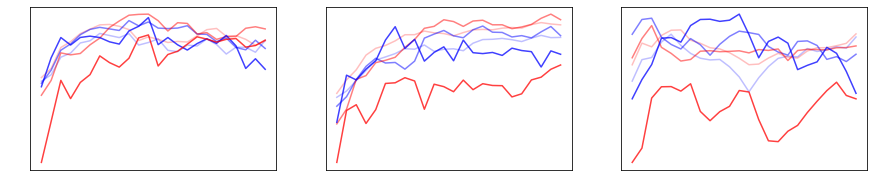

In [77]:
fig, axs = plt.subplots(1,3, figsize=(15,3))

for i in range(3):
    for l_idx in range(1,len(ls)):
        axs[i].plot(updates_gVar[:,l_idx,i], c="blue", alpha=(0.25+0.75*(l_idx-1)/(len(ls)-1)))
        axs[i].plot(updates_gVar_diff[:,l_idx-1,i], c="red", alpha=(0.25+0.75*(l_idx-1)/(len(ls)-1)))